In [1]:
import pandas as pd
import numpy as np
import gzip
import itertools
import multiprocessing
import csv
import pickle
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm, tqdm_notebook
from multiprocessing import Manager, Pool
from scipy.spatial.distance import cdist
from numpy.linalg import norm
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt

In [76]:
def draw_histogram_for_similarites(similarityMatrixFileName):
    human_proteinSimilarityMatrix = pd.read_csv(similarityMatrixFileName)
    fig, ax = plt.subplots()
    plt.grid(True,linewidth=0.5,ls='--')
    plt.tick_params(labelsize=18)
    ax.set_axisbelow(True)
    fig.tight_layout() 
    plt.hist(human_proteinSimilarityMatrix.values.flatten(), edgecolor='black', linewidth=1.2)
    

In [64]:
similarityMatrixFileName = "/media/DATA/serbulent/Code/Thesis/ReviewPaper/preprocess/human_MF_proteinSimilarityMatrix_for_highest_annotated_500_proteins.csv"
#similarityMatrixFileName = "/media/DATA/serbulent/Code/Thesis/ReviewPaper/preprocess/human_BP_proteinSimilarityMatrix_for_highest_annotated_500_proteins.csv"
#similarityMatrixFileName = "/media/DATA/serbulent/Code/Thesis/ReviewPaper/preprocess/human_CC_proteinSimilarityMatrix_for_highest_annotated_500_proteins.csv"

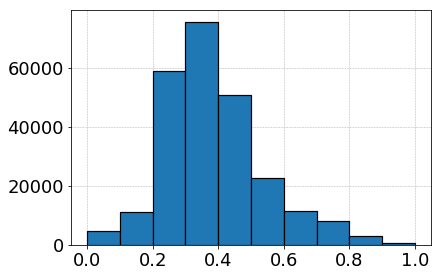

In [77]:
draw_histogram_for_similarites(similarityMatrixFileName)

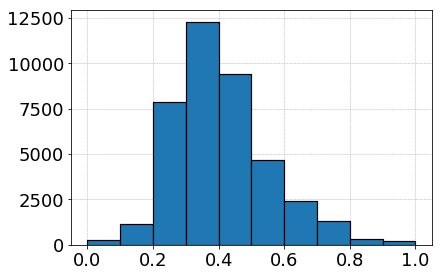

In [79]:
similarityMatrixFileName = "/media/DATA/serbulent/Code/Thesis/ReviewPaper/preprocess/human\
_MF_proteinSimilarityMatrix_for_highest_annotated_200_proteins.csv"
draw_histogram_for_similarites(similarityMatrixFileName)

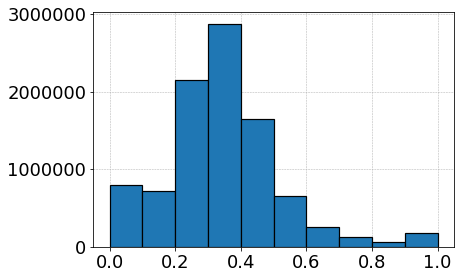

In [80]:
similarityMatrixFileName = "/media/DATA/serbulent/Code/Thesis/ReviewPaper/preprocess/human_MF_proteinSimilarityMatrix.csv"
draw_histogram_for_similarites(similarityMatrixFileName)

In [81]:
#Adapted from https://stackoverflow.com/questions/38768474/python-subset-of-list-as-equally-distributed-as-possible
# An alternative bight be; https://stackoverflow.com/questions/50685409/select-n-evenly-spaced-out-elements-in-array-including-first-and-last
def subset_evenly(zipped_list, length_list, possible_values):
    a = min(possible_values)
    b = max(possible_values)
    chunk_size = (b-a)/(length_list+1)
    #print(chunk_size)
    new_list = []
    for i in tqdm_notebook(range(1,length_list+1)):
        index = a+i*chunk_size
        #print(index)
        #get nearest number to ith chunk
        # see http://www.trytoprogram.com/python-programming/python-built-in-functions/min/
        # for usage of key parameter in min()
        sampled_value = min(zipped_list, key=lambda x:abs(x[0]-index))
        new_list.append(sampled_value)
        #We need to remove sampled number since it might be sampled more than once
        #somelist.remove(sampled_value)
        zipped_list = [tup for tup in zipped_list if tup[0] != sampled_value[0]]
    return new_list

Store real similarities with indexes

In [82]:
human_proteinSimilarityMatrix = pd.read_csv("/media/DATA/serbulent/Code/Thesis/ReviewPaper/preprocess/\
human_MF_proteinSimilarityMatrix_for_highest_annotated_500_proteins.csv")
real_sim_index = range(0,len(human_proteinSimilarityMatrix.values.flatten()))
real_sims_list = list(human_proteinSimilarityMatrix.values.flatten())
real_sims_indexed_zip = zip(real_sims_list,real_sim_index)
real_sims_indexed = []
for tup in real_sims_indexed_zip:
    real_sims_indexed.append(tup)
len(real_sims_indexed)

247009

In [74]:
sampled_list = subset_evenly(real_sims_indexed, int(len(real_sims_list)/1000), real_sims_list)


(array([24., 25., 25., 25., 24., 25., 25., 25., 25., 24.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

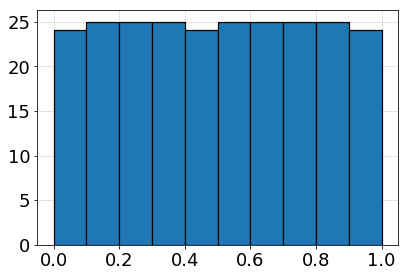

In [83]:
unzipped_sampled_list = list(zip(*sampled_list))
filtered_indexes = unzipped_sampled_list[1]

fig, ax = plt.subplots()
plt.grid(True,linewidth=0.5,ls='--')
plt.tick_params(labelsize=18)
ax.set_axisbelow(True)
fig.tight_layout()
plt.hist(unzipped_sampled_list[0], edgecolor='black', linewidth=1.2)

In [182]:
def draw_histogram_for_multiple_similarites(data1,data2,data3,data4):
    fig, axs = plt.subplots(2, 2)
    
    #plt.tick_params(labelsize=18)
    fig.tight_layout()

    axs[0,0].hist(data1, edgecolor='black', linewidth=1.2)
    axs[0,0].set_title("All Proteins")
    axs[0,0].tick_params(labelbottom=False)
    axs[0,0].set(ylabel='Number of Proteins')
    axs[0,1].hist(data2, edgecolor='black', linewidth=1.2)
    axs[0,1].set_title("Well Annotated 500")
    axs[0,1].tick_params(labelbottom=False)
    axs[1,0].hist(data3, edgecolor='black', linewidth=1.2)
    axs[1,0].set_title("Well Annotated 200")
    axs[1,0].set(xlabel='Semantic Similarity', ylabel='Number of Proteins')
    axs[1,1].hist(data4, edgecolor='black', linewidth=1.2)
    axs[1,1].set_title("Sparsified Uniform")
    axs[1,1].set(xlabel='Semantic Similarity')

    for ax in axs.flat:
        ax.set_axisbelow(True)
        ax.grid(True,linewidth=0.5,ls='--')
        ax.get_yaxis().set_label_coords(-0.35,0.5)

In [109]:
human_proteinSimilarityMatrix_500 = pd.read_csv("/media/DATA/serbulent/Code/Thesis/ReviewPaper/preprocess/\
human_MF_proteinSimilarityMatrix_for_highest_annotated_500_proteins.csv")
human_proteinSimilarityMatrix_200 = pd.read_csv("/media/DATA/serbulent/Code/Thesis/ReviewPaper/preprocess/human\
_MF_proteinSimilarityMatrix_for_highest_annotated_200_proteins.csv")
human_proteinSimilarityMatrix_all = pd.read_csv("/media/DATA/serbulent/Code/Thesis/ReviewPaper/preprocess/human\
_MF_proteinSimilarityMatrix.csv")

data1 = human_proteinSimilarityMatrix_all.values.flatten()
data2 = human_proteinSimilarityMatrix_500.values.flatten() 
data3 = human_proteinSimilarityMatrix_200.values.flatten()
data4 = unzipped_sampled_list[0]

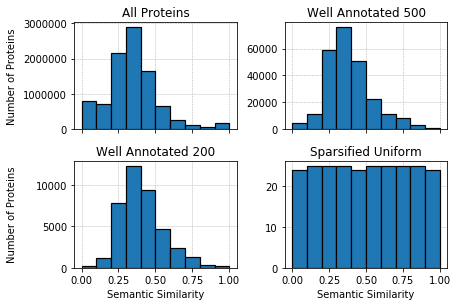

In [183]:
draw_histogram_for_multiple_similarites(data1,data2,data3,data4)

In [ ]:
len(filtered_indexes)

Calculate 2D coordinates of sparsified similarities

In [ ]:
filtered_indexes_zip = zip(*np.unravel_index(filtered_indexes, human_proteinSimilarityMatrix.shape))

coordinate_list = []
for coordinate in filtered_indexes_zip:
    coordinate_list.append(coordinate)
    
coordinate_list

In [ ]:
#saveCoordinateFileName = "SparsifiedSimilarityCoordinates_CC_for_highest_500.npy"
#np.save(saveCoordinateFileName,coordinate_list)

#saveSimilarityFileName = "SparsifiedSimilarites_MF_for_highest_500.npy"
#np.save(saveSimilarityFileName,unzipped_sampled_list[0])